# Representation Learning and Generative Learning Using Autoencoders and GANs
The idea behind learning useful data representations is simple - stack several layers (dense, convolutional, recurrent) and make the model learn the identity function (so this is an usupervised or self-supervised learning task). By adding certain constraints this forces the model not to trivially memorize all the data points but rather learn most informative patterns.

Examples of how to add a constraint:
* Make a stack of layers with the central (middle) ones having less units than the input and output
* Adding noise to the inputs
* Adding dropout to the input layer (during training)
* Inhibit portion of neurons in the coding layer by penalizing their activation in the loss function

Efficient representation is useful in several areas:
* Feature extraction
* Unupervised pre-training (pre-training model on unlabeled data)
* Dimensionality reduction, for instance for visualization (this can be two step: first reducing data using an autoencoder, then more classical but less scalable model)
* Removing noise from the data
* Generating new data if the model supports it (is *generative*)
* Anomaly detection (autoencoders are generally bad at reconstructing outliers)

In [1]:
# FIXME: meke autocompletion working again
%config Completer.use_jedi = False

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')

if not physical_devices:
    print("No GPU was detected.")
else:
    # https://stackoverflow.com/a/60699372
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
from tensorflow import keras


def plot_image(image):
    """Plot a grayscale image"""
    plt.imshow(image, cmap="binary")
    plt.axis("off")

No GPU was detected.


### PCA with a linear Autoencoder

In [2]:
# Set RNG state
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data


# Generate a centered 3D dataset
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [3]:
# Set RNG state
np.random.seed(42)
tf.random.set_seed(42)

data_dim = X_train.shape[-1]
repr_dim = 2

# Build simple linear autoencoder that performs PCA
encoder = keras.models.Sequential([keras.layers.Dense(repr_dim, input_shape=[data_dim])])
decoder = keras.models.Sequential([keras.layers.Dense(data_dim, input_shape=[repr_dim])])
autoencoder = keras.models.Sequential([encoder, decoder])

# Compile the model
#  - We use MSE to make it equivalent to PCA
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2726
Epoch 2/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1026
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0547
Epoch 4/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0512
Epoch 5/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0773
Epoch 6/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2136
Epoch 7/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1043
Epoch 8/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 9/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0241
Epoch 10/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0195
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 13/20
2/2 [==============================] - 0s 4ms/step - loss: 0.

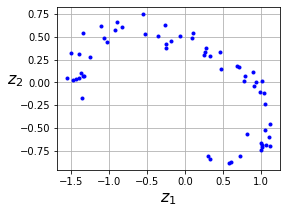

In [4]:
# Retrieve learned representation from the encoder part
codings = encoder.predict(X_train)

# Plot the representation
fig = plt.figure(figsize=(4, 3))

plt.plot(codings[:, 0], codings[:, 1], "b.")

plt.xlabel("$z_1$", fontsize=16)
plt.ylabel("$z_2$", fontsize=16, rotation=0)
plt.grid(True)

plt.show()

## Stacked Autoencoders

In [5]:
# Load, split and scale the Fashion MNIST dataset

max_val = 255
val_split = 5000

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / max_val
X_test = X_test.astype(np.float32) / max_val
X_train, X_valid = X_train_full[:-val_split], X_train_full[-val_split:]
y_train, y_valid = y_train_full[:-val_split], y_train_full[-val_split:]

### Train all layers at once
First way how to train autoencoders is to tread the model as any other and train all the layers at once.

In [6]:
# Set RNG state
tf.random.set_seed(42)
np.random.seed(42)


def rounded_accuracy(y_true, y_pred):
    """
    Typical metric that treats the problem as a binary classification, 
    assumes that the outputs are from `[0, 1]` interval (e.g. from sigmoid)
    and computes a binary accuracy after rounding both (which sends them to either 0 or 1).
    """
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


input_shape = [28, 28]
output_dim = input_shape[0] * input_shape[1]
repr_dim = 30

# Encoder part
#  - two dense layers with SELU activations
#  - converts an 28x28 image to a 30 dimensional vector
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(repr_dim, activation="selu"),
])

# Decoder part
#  - mirrors the encoder architecture but final activation is a sigmoid
#  - reconstructs a 30 dimensional input back to 28x28 image
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[repr_dim]),
    keras.layers.Dense(output_dim, activation="sigmoid"),
    keras.layers.Reshape(input_shape)
])

# Build and compile the autoencoder
#  - We treat the problem as a binary classification (multi-label) an use the `binary_crossentropy` loss
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])

# Train and validate the model using inputs as targets
history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 3ms/step - loss: 0.3814 - rounded_accuracy: 0.8487 - val_loss: 0.3169 - val_rounded_accuracy: 0.8998
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3083 - rounded_accuracy: 0.9126 - val_loss: 0.3021 - val_rounded_accuracy: 0.9200
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2997 - rounded_accuracy: 0.9204 - val_loss: 0.2982 - val_rounded_accuracy: 0.9206
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2959 - rounded_accuracy: 0.9240 - val_loss: 0.2937 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2928 - rounded_accuracy: 0.9269 - val_loss: 0.2919 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2920 - rounded_accuracy: 0.9283 - val_loss: 0.2916 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

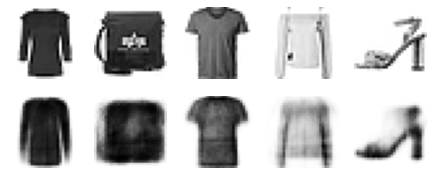

In [7]:
def show_reconstructions(model, images=X_valid, n_images=5):
    """
    Take `n_images` from the given set of images and plot 
    original ones as well as their representation produced 
    by the model.
    """
    reconstructions = model.predict(images[:n_images])
    
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    
    for i, reconstruction in enumerate(reconstructions):
        # Plot the original image
        plt.subplot(2, n_images, 1 + i)
        plot_image(images[i])
        
        # Plot the reconstruction
        plt.subplot(2, n_images, 1 + n_images + i)
        plot_image(reconstruction)


show_reconstructions(stacked_ae)

### Visualizing Fashion MNIST
As mentioned before, it is quite common in data visualization to use autoencoders for dimensionality reduction before applying another algorithm to convert the representation to 2D. This can overcome the problem of many robust dimensionality reduction algorithms that don't scale well with the number of features. Here's an example of an autoencoder t-SNE combo.

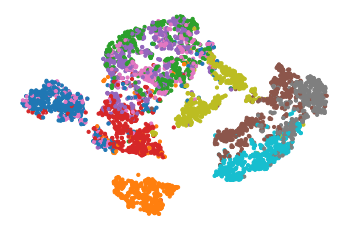

In [8]:
from sklearn.manifold import TSNE

# Reset RNG stete
np.random.seed(42)

# Use the last stacked autoencoder to compress the validation datas
X_valid_compressed = stacked_encoder.predict(X_valid)

# Finish the dimensionality reduction with a t-SNE model
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

# Scale (normalize) the final 2D data to unit interval
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

# Plot the resulting 2D representation of the Fashion MNIST dataset
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

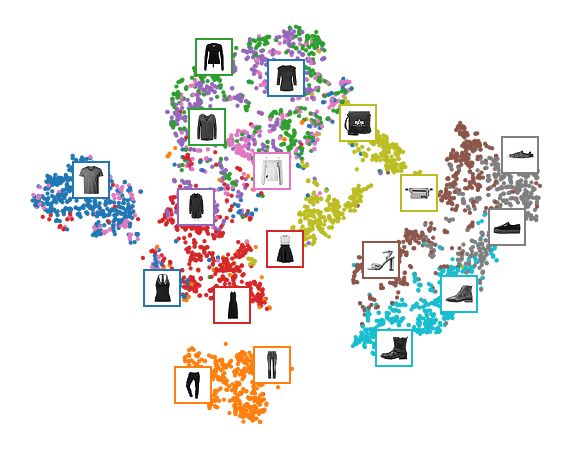

In [9]:
import matplotlib as mpl

# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))

cmap = plt.cm.tab10

# Plot the 2D data
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    
    dist = np.sum((position - image_positions) ** 2, axis=1)
    
    # if far enough from other images
    if np.min(dist) > 0.02:
        image_positions = np.r_[image_positions, [position]]
        
        # Make a class annotation
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position,
            bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2}
        )
        plt.gca().add_artist(imagebox)
        
plt.axis("off")

plt.show()

### Tying weights
It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. This is possible with a symmetric architecture of the autoencoder and reduces the number of trainable parameters. For this, we need to use a custom layer.

In [10]:
# Reset RNG state and TF session
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


class DenseTranspose(keras.layers.Layer):
    """
    Custom layer that shares weights with given dense layer but
    applies them transposed. It, however, has its own biases.
    """
    
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    
    def build(self, batch_input_shape):
        # This layer has its own biases
        self.biases = self.add_weight(
            name="bias",
            shape=[self.dense.input_shape[-1]],
            initializer="zeros",
        )
        super().build(batch_input_shape)
        
    def call(self, inputs):
        # Compute the output as `X * W^T + b`
        #  - `transpose_b=True` is an efficient way how to do the transpose during the matrix multiplication
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)
    

# Make two encoder layers, weights of which will be reused
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(repr_dim, activation="selu")

# First part is standard stacked encoder
tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    dense_1,
    dense_2
])

# The decoder is very similar
#  - The only difference is in `DenseTranspose` which ties weights to the encoder
tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape(input_shape)
])

# Build the autoencoder model with tied weights between encoder and decoder
tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])

# Train and validate the model using inputs as targets
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3701 - rounded_accuracy: 0.8581 - val_loss: 0.3080 - val_rounded_accuracy: 0.9080
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2998 - rounded_accuracy: 0.9202 - val_loss: 0.2951 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2928 - rounded_accuracy: 0.9266 - val_loss: 0.3013 - val_rounded_accuracy: 0.9094
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2898 - rounded_accuracy: 0.9294 - val_loss: 0.2880 - val_rounded_accuracy: 0.9333
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2869 - rounded_accuracy: 0.9322 - val_loss: 0.2874 - val_rounded_accuracy: 0.9315
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2865 - rounded_accuracy: 0.9334 - val_loss: 0.2860 - val_rounded_accuracy: 0.9354
Epoch 7/10
1719/1719 [==================

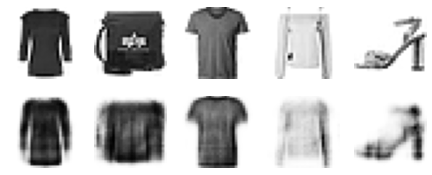

In [11]:
show_reconstructions(tied_ae)
plt.show()

### Training one Autoencoder at a Time
Another way how to train autoencoders is to use unsupervised pre-training and first train the outer envelopes of the autoencoder model and in the next step add middle layers and so on...

In [12]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend


def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)


# Flatten the datasets
#  - This is equivalent to `.reshape(-1, 28 * 28)`
X_train_flat = K.batch_flatten(X_train)
X_valid_flat = K.batch_flatten(X_valid)

# Make the first training step
#  - Loss is `binary_crossentropy` because we're training the final output layer
#  - For the same reason we use sigmoid activation in the decoder
#  - And we start with fairly high learning rate
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    n_neurons=100,
    X_train=X_train_flat,
    X_valid=X_valid_flat,
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=1.5),
    output_activation="sigmoid",
    metrics=[rounded_accuracy],
)

# Make the second training step (for this network it's the last one)
#  - Loss is MSE because we're training the inner layers
#  - For the same reason we use SELU activation in the decoder
#  - And we lower the learning rate quite a bit
#  - Finally the inputs are the outputs from the previous step
enc2, dec2, _, _ = train_autoencoder(
    n_neurons=repr_dim,
    X_train=X_train_enc1,
    X_valid=X_valid_enc1,
    loss="mse",
    optimizer=keras.optimizers.SGD(lr=0.05),
    output_activation="selu",
)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3952 - rounded_accuracy: 0.8460 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3070 - rounded_accuracy: 0.9176 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2967 - rounded_accuracy: 0.9267 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2906 - rounded_accuracy: 0.9328 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2860 - rounded_accuracy: 0.9372 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2844 - rounded_accuracy: 0.9396 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

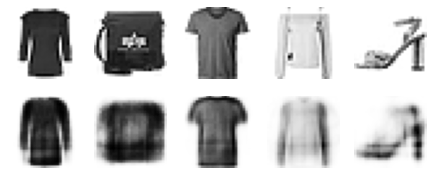

In [13]:
# Compose both steps into the final autoencoder
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    enc1,
    enc2,
    dec2,
    dec1,
    keras.layers.Reshape(input_shape)
])

# Show model's reconstruction capabilities
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [14]:
# Re-compile and re-train the model

stacked_ae_1_by_1.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=0.1),
    metrics=[rounded_accuracy],
)

history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2866 - rounded_accuracy: 0.9339 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2866 - rounded_accuracy: 0.9345 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2861 - rounded_accuracy: 0.9348 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2863 - rounded_accuracy: 0.9349 - val_loss: 0.2877 - val_rounded_accuracy: 0.9349
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2868 - rounded_accuracy: 0.9352 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

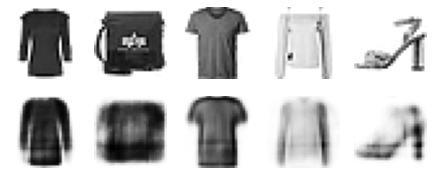

In [15]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Convolutional Autoencoders
Most convolutional autoencoders work by constraining (reducing) the spatial dimension while adding more feature maps and then reconstructing the original. For the encoder it's as easy to create a convolutional version with all the 2D conv and pooling layers. For the decoder part, there's a `Conv2DTranspose`.

In [16]:
# Set RNG state
tf.random.set_seed(42)
np.random.seed(42)

# Convolutional encoder
#  - Converts 28x28 grayscale images (single channel) to 3x3 images with 64 filters
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=input_shape),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

# Convolutional encoder
#  - Converts 3x3 images with 64 filters back to 28x28 grayscale images
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu", input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape(input_shape)
])

# Build the convolutional autoencoder
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0), metrics=[rounded_accuracy])

# Train and validate the model using inputs as targets
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3377 - rounded_accuracy: 0.8895 - val_loss: 0.2852 - val_rounded_accuracy: 0.9279
Epoch 2/5
1719/1719 [==============================] - 32s 19ms/step - loss: 0.2777 - rounded_accuracy: 0.9393 - val_loss: 0.2729 - val_rounded_accuracy: 0.9455
Epoch 3/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.2717 - rounded_accuracy: 0.9451 - val_loss: 0.2696 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2690 - rounded_accuracy: 0.9482 - val_loss: 0.2685 - val_rounded_accuracy: 0.9492
Epoch 5/5
1719/1719 [==============================] - 32s 19ms/step - loss: 0.2669 - rounded_accuracy: 0.9505 - val_loss: 0.2673 - val_rounded_accuracy: 0.9505


In [17]:
# Display the encoder and decoder architecture
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

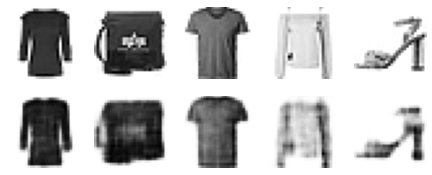

In [18]:
show_reconstructions(conv_ae)
plt.show()

## Recurrent Autoencoders
Recurrent autoencoders work basically the same way. Following examples a model that takes a Fashion MNIST image and treats it as a sequence of rows - i.e. 28 dimensional feature vector. Then it crates a single vector representation and decodes it back to a sequence (image).

In [19]:
# Recurrent encoder
#  - The input image is treated as a 28-step sequence with each step being a 28-feature vector
#  - The second (final) recurrent laye outputs the last vector (not a sequence) and has no. units equal to the representation size
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=input_shape),
    keras.layers.LSTM(repr_dim)
])

# Recurrent decoder
#  - First repeats the input representation for each time frame
#  - Then it reconstructs the sequence into an image
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[repr_dim]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

# Compose the autoencoder model
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1), metrics=[rounded_accuracy])

# Train and validate the model using inputs as targets
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 69s 38ms/step - loss: 0.5628 - rounded_accuracy: 0.7075 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 82s 48ms/step - loss: 0.4278 - rounded_accuracy: 0.8285 - val_loss: 0.3748 - val_rounded_accuracy: 0.8693
Epoch 3/10
1719/1719 [==============================] - 72s 42ms/step - loss: 0.3698 - rounded_accuracy: 0.8676 - val_loss: 0.3604 - val_rounded_accuracy: 0.8767
Epoch 4/10
1719/1719 [==============================] - 77s 45ms/step - loss: 0.3541 - rounded_accuracy: 0.8788 - val_loss: 0.3524 - val_rounded_accuracy: 0.8773
Epoch 5/10
1719/1719 [==============================] - 82s 48ms/step - loss: 0.3422 - rounded_accuracy: 0.8865 - val_loss: 0.3361 - val_rounded_accuracy: 0.8921
Epoch 6/10
1719/1719 [==============================] - 72s 42ms/step - loss: 0.3358 - rounded_accuracy: 0.8910 - val_loss: 0.3306 - val_rounded_accuracy: 0.8964
Epoch 7/10
1719/1719 [======

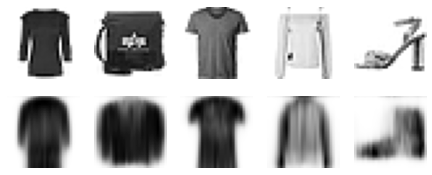

In [20]:
show_reconstructions(recurrent_ae)
plt.show()

## Stacked denoising Autoencoder
As mentioned at the beginning another way how to force an autoencoder to learn something useful is to add noise. There are two approaches presented below:
1. Add Gaussian noise to the inputs
1. Add noise through random dropout at the input level

### Using Gaussian noise

In [21]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

# The encoder
#  - We add a `GaussianNoise` layer right after the inputs
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(repr_dim, activation="selu")
])

# The decoder
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[repr_dim]),
    keras.layers.Dense(output_dim, activation="sigmoid"),
    keras.layers.Reshape(input_shape)
])

# Build the denoising autoencoder
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0), metrics=[rounded_accuracy])

# Train and validate the model using inputs as targets
history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4007 - rounded_accuracy: 0.8323 - val_loss: 0.3182 - val_rounded_accuracy: 0.9036
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3146 - rounded_accuracy: 0.9075 - val_loss: 0.3087 - val_rounded_accuracy: 0.9156
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3067 - rounded_accuracy: 0.9141 - val_loss: 0.3035 - val_rounded_accuracy: 0.9191
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3032 - rounded_accuracy: 0.9173 - val_loss: 0.2999 - val_rounded_accuracy: 0.9207
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2998 - rounded_accuracy: 0.9205 - val_loss: 0.2968 - val_rounded_accuracy: 0.9252
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2985 - rounded_accuracy: 0.9222 - val_loss: 0.2947 - val_rounded_accuracy: 0.9272
Epoch 7/10
1719/1719 [==================

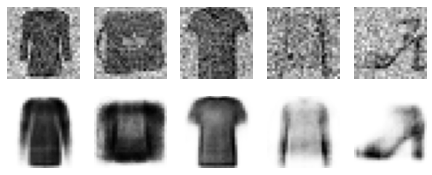

In [22]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

# Add some noise to the validation data
noise = keras.layers.GaussianNoise(0.2)
X_valid_with_noise = noise(X_valid, training=True)

# Show the originals and denoised results
show_reconstructions(denoising_ae, X_valid_with_noise)
plt.show()

### Using dropout

In [23]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

# The encoder
#  - We add a `Dropout` layer which will be active during training
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(repr_dim, activation="selu")
])

# The decoder
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[repr_dim]),
    keras.layers.Dense(output_dim, activation="sigmoid"),
    keras.layers.Reshape(input_shape)
])

# Build the denoising autoencoder
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0), metrics=[rounded_accuracy])

# Train and validate the model using inputs as targets
history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4073 - rounded_accuracy: 0.8261 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3203 - rounded_accuracy: 0.9017 - val_loss: 0.3126 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3136 - rounded_accuracy: 0.9067 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3102 - rounded_accuracy: 0.9094 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3070 - rounded_accuracy: 0.9121 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3063 - rounded_accuracy: 0.9132 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

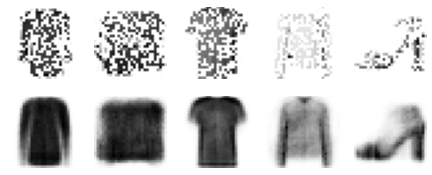

In [24]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

# Show the results
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

## Sparse Autoencoder
Yet another method how to constrain an autoencoder takes a different approach. The coding layer is not restricted in the number of units (it can even have more neurons than is the input dimension) but rather inhibit them by adding an activation penalty to the loss function. This makes a sparse model.

We'll show two types of penalties, first the $\ell_1$ regularization and then KL divergence. But let's start with a standard autoencoder for comparison (using sigmoid activations to have codings in $[0, 1]$ interval).

In [25]:
# Set RNG state
tf.random.set_seed(42)
np.random.seed(42)

# Build stacked autoencoder
#  - This model uses sigmoid activation for the coding layer so representations take values from [0, 1]

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(repr_dim, activation="sigmoid"),
])

simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[repr_dim]),
    keras.layers.Dense(output_dim, activation="sigmoid"),
    keras.layers.Reshape(input_shape)
])

simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.), metrics=[rounded_accuracy])

# Train and validate the model using inputs as targets
history = simple_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4876 - rounded_accuracy: 0.7450 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3679 - rounded_accuracy: 0.8591 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3442 - rounded_accuracy: 0.8824 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3317 - rounded_accuracy: 0.8930 - val_loss: 0.3263 - val_rounded_accuracy: 0.8991
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3223 - rounded_accuracy: 0.9006 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3194 - rounded_accuracy: 0.9030 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [==================

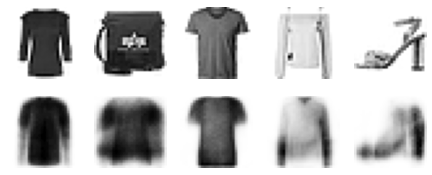

In [26]:
show_reconstructions(simple_ae)
plt.show()

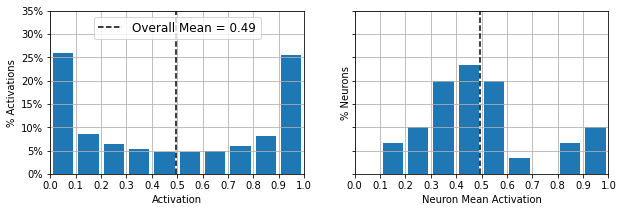

In [27]:
def plot_percent_hist(ax, data, bins):
    # Compute a histogram from given data on the bins
    counts, _ = np.histogram(data, bins=bins)
    
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    
    # Plot the histogram
    ax.bar(x, counts / len(data), width=widths*0.8)
    
    # Add styling to the histogram
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda y, _: f"{int(np.round(100 * y))}%")
    )
    ax.grid(True)

    
def plot_activations_histogram(encoder, height=1, n_bins=10):
    # Get the representation
    X_valid_codings = encoder(X_valid).numpy()
    
    # Compute mean activations
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    
    # Crate histogram bins
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    
    # Plot histogram of activations
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label=f"Overall Mean = {mean:.2f}")
    ax1.legend(loc="upper center", fontsize=12)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    
    # Plot histogram of neuron mean activations
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])


plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

### $\ell_1$ regularization
Let's note that $\ell_2$ regularization would not work as well because the loss would minimize the size of weights over all the neurons rather than completely inhibit some as the $\ell_1$ does.

In [28]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

coding_units = 300

# Sparse encoder
#  - The coding layer uses much more units than is the representation size
#  - We add an activity l1 regularization on top of the coding layer
#  - Equivalently, one can set `activity_regularizer=keras.regularizers.l1(1e-3)` on the coding layer
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(coding_units, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3),
])

# The decoder
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[coding_units]),
    keras.layers.Dense(output_dim, activation="sigmoid"),
    keras.layers.Reshape(input_shape)
])

# Compose the sparse autoencoder
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0), metrics=[rounded_accuracy])

# Train and validate the model using inputs as targets
history = sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4971 - rounded_accuracy: 0.7657 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3733 - rounded_accuracy: 0.8649 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3578 - rounded_accuracy: 0.8773 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3460 - rounded_accuracy: 0.8860 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3383 - rounded_accuracy: 0.8914 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3342 - rounded_accuracy: 0.8953 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

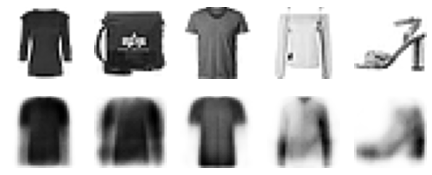

In [29]:
show_reconstructions(sparse_l1_ae)

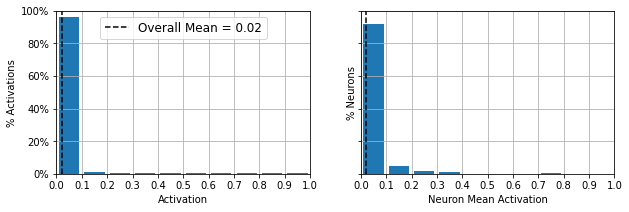

In [30]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

### KL Divergence
Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%.

*Notice that KL divergence has steeper gradients so the training can perform better.*

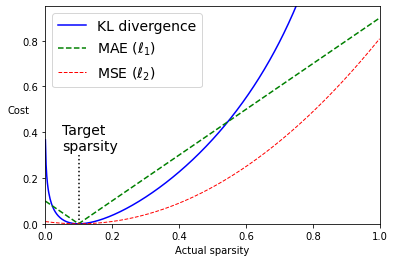

In [31]:
# Target sparsity
p = 0.1

# Space of actual sparsities
q = np.linspace(0.001, 0.999, 500)

# Compute the relative entropy D(p || q)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))

# Compute MSE and MAE for comparison with l2 and l1 regularizations
mse = (p - q)**2
mae = np.abs(p - q)

# Plot the target sparsity
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)

# Plot KL divergence, MAE and MSE
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")

# Add some styling to the figure
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

plt.show()

In [32]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence


class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    """Custom weighted KL divergence regularizer"""
    
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    
    def __call__(self, inputs):
        # Compute neuron mean activities
        mean_activities = K.mean(inputs, axis=0)
        # Compute KL divergence between the actual and target neuron activity
        kl_div = kl_divergence(self.target, mean_activities) + kl_divergence(1. - self.target, 1. - mean_activities)
        # Return weighted KL divergence
        return self.weight * kl_div


# Sparse encoder
#  - We use custom KL divergence activity regularizer on the coding layer
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(
        coding_units,
        activation="sigmoid",
        activity_regularizer=KLDivergenceRegularizer(weight=0.05, target=0.1),
    )
])

# The decoder
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[coding_units]),
    keras.layers.Dense(output_dim, activation="sigmoid"),
    keras.layers.Reshape(input_shape),
])

# Compose the sparse autoencoder
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0), metrics=[rounded_accuracy])

# Train and validate the model using inputs as targets
history = sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4753 - rounded_accuracy: 0.7629 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3606 - rounded_accuracy: 0.8686 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3374 - rounded_accuracy: 0.8887 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3247 - rounded_accuracy: 0.9000 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3178 - rounded_accuracy: 0.9057 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3153 - rounded_accuracy: 0.9083 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [==================

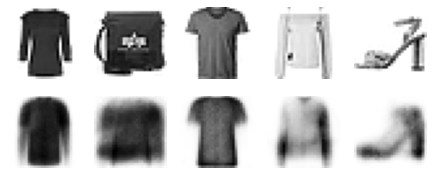

In [33]:
show_reconstructions(sparse_kl_ae)

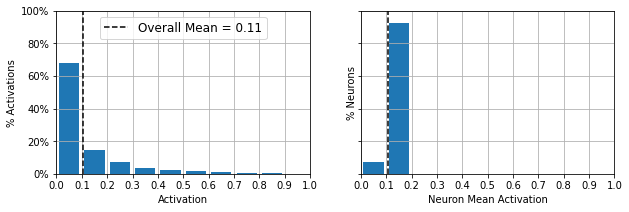

In [34]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

## Variational Autoencoder
Next version of an autoencoder is a *generative* model that is capable of producing new instances that resemble training instances - in this case, MNIST images. Variational autoencoders look almost the same as regular stacked autoencoders except the coding part. This part is quite different and makes them also *probabilistic* (during inference).

The encoder part does not directly produce single coding but rather two vectors:
* $\mathbf{\mu}$ - mean coding
* $\mathbf{\sigma}$ - standard deviation

These coding parameters are used to sample a coding from Gaussian distribution with respective mean and standard deviation (similarly to how variational Bayesian inference works). Actually, variational autoencoders are more general and are able to work with other distributions as well. These sampled codings are then decoded in standard manner.

To train the network properly we extend the loss function as well. First part of the loss is the *reconstruction loss* as we've used before which forces the autoencoder to learn to reconstruct the training instance. The additional part is a *latent loss* that pushes the autoencoder to produce codings that look like they were sampled from a Gaussian distribution. The latent loss is a KL divergence between the target Gaussian distribution and the actual distribution of the codings and simplifies to
$$
\mathcal{L} = - \frac{1}{2} \sum_{i = 1}^n[1 + \log(\sigma_i^2) - \sigma_i^2 - \mu_i^2]
$$
where $n$ is the coding size. Finally, there's a trick to make the loss computation more numerically stable which is a simple substitution $\mathbf{\gamma} = \log(\mathbf{\sigma}^2)$:
$$
\mathcal{L} = - \frac{1}{2} \sum_{i = 1}^n[1 + \gamma_i - \exp(\gamma_i) - \mu_i^2]
$$

In [35]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

class Sampling(keras.layers.Layer):
    """Sampling layer for a variational autoencoder"""
    
    def call(self, inputs):
        mean, log_var = inputs
        std = K.exp(log_var / 2)
        return K.random_normal(tf.shape(log_var)) * std + mean


# Encoder producing two kinds of outputs: 
#  1. coding mean and log variance 
#  2. coding sampled from Gaussian with respective mean and std
inputs = keras.layers.Input(shape=input_shape)
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs],
    outputs=[codings_mean, codings_log_var, codings]
)

# The decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(output_dim, activation="sigmoid")(x)
outputs = keras.layers.Reshape(input_shape)(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

# Compose variational autoencoder
#  - We can ignore outputs corresponding to the distribution parameters
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# Manually compute and register the latent loss
#  - This is done manually to add the scaling factor
#  - Without scaling our two components of the loss function would have very different scales
loss_scaling_factor = 784.
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / loss_scaling_factor)

# Compile the model
#  - We use RMSprop which works well in this case
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

# Train and validate the model using inputs as targets
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 5s 9ms/step - loss: 0.4436 - rounded_accuracy: 0.8155 - val_loss: 0.3497 - val_rounded_accuracy: 0.8974
Epoch 2/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3460 - rounded_accuracy: 0.8951 - val_loss: 0.3353 - val_rounded_accuracy: 0.9075
Epoch 3/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3341 - rounded_accuracy: 0.9041 - val_loss: 0.3383 - val_rounded_accuracy: 0.9041
Epoch 4/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3290 - rounded_accuracy: 0.9083 - val_loss: 0.3283 - val_rounded_accuracy: 0.9124
Epoch 5/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3252 - rounded_accuracy: 0.9116 - val_loss: 0.3280 - val_rounded_accuracy: 0.9113
Epoch 6/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3242 - rounded_accuracy: 0.9129 - val_loss: 0.3231 - val_rounded_accuracy: 0.9153
Epoch 7/25
430/430 [==============================] 

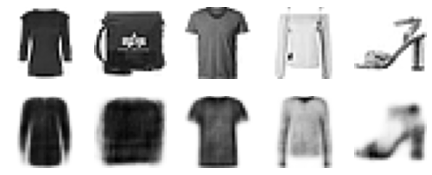

In [36]:
show_reconstructions(variational_ae)
plt.show()

### Generate Fashion Images
Let's generate a few random codings, decode them and plot the resulting images.

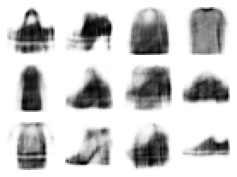

In [37]:
# Set RNG state
tf.random.set_seed(42)


def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
        
    plt.figure(figsize=(n_cols, n_rows))
    
    for i, image in enumerate(images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


# Sample 12 codings from the model and generate new images by decoding them
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

# Show generated images
plot_multiple_images(images, 4)

Generative models are also capable of *semantic interpolation*. Let's imagine we'd interpolate images by computing their mean. This would result in an image with bunch of overlaping images. In semantic interpolation we also compute a mean but the difference is that we do than in the coding space. After decoding we get much better result.

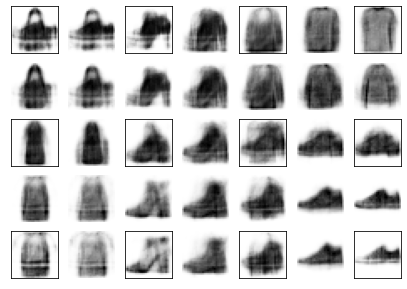

In [38]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

# Take a 3x4 grid and resize it to 5x7
#  - `resize` performs by default a bilinear interpolation
#  - so every row and column in larger grid contains interpolated codings
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])

# Reshape and decode interpolated codings
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

# Plot the images
#  - original images are framed
#  - the rest is result of semantic interpolation of nearby images
plt.figure(figsize=(7, 5))

for i, image in enumerate(images):
    plt.subplot(5, 7, i + 1)
    
    if i % 7 % 2 == 0 and i // 7 % 2 == 0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
        
    plt.imshow(image, cmap="binary")

## Generative Adversarial Networks
*Generative Adversarial Networks (GANs)* are also a generative model but are build on a slightly different premise. There are two components competing with each other:
* **The discriminator** is a binary classifier that tries to tell if an input instance is fake or real
* **The generator** is a component that can produce fake instances from random noise to fool the discriminator

The setup is fairly straightforward but what's quite challenging is how to train these networks. GANs aactually train both components separately and one step at a time:
1. We take some real instances and generate some new (fake) ones from the generator and update the discriminator with a single batch of `[fake; real]` labeled instances
1. Then we freeze the discriminator, generate new instances with the generator and label them real (to teach it fake instanecs for the discriminator) and update the rest of the GAN

Interestingly, during the training the generator is never shown an actual real instance from the training dataset, yet through the learning process (by trying to fool the discriminator) it figures out what these look like.

The learning dynamics is essentially a two-player zero-sum game and an optimum state the learning process can end up in is a *Nash Equilibrium (NE)* of this game. In this NE the generator learns to produce perfectly realistic instances and the discriminator is forced to play uniform strategy (50-50). The difficulty in training GANs is that the learning is very sensitive to heperparameter setup and thus unstable. 

A typical problem that arises is *mode collapse* - a situation during training in which the generator gets particularly good in faking certain class of instances. Because of that it's incentivise to exploit this fact and starts playing (generating) these instances even more while forgetting what it's learned about the rest. In response the discriminator starts focusing on this class as well and after make the generator best respond and re-learn another class. The whole collapse can repeat many times and both components never learn somethig useful about the problem as a whole. Some semi-successful approaches to deal with this issue are:
* *experience replay* - keeping a buffer of recently produced instances and sampling new ones by the generator from this history and training it on real instances as well
* *mini-batch discrimination* - the discriminator measures a similarity of instances in a mini-batch and rejects the whole batch if it lacks diversity

Epoch 1/1


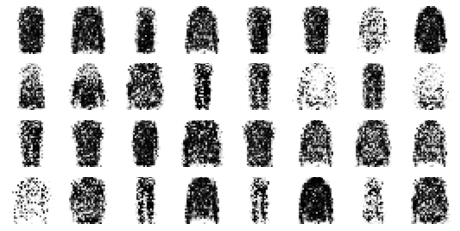

In [39]:
# Set RNG state
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

# The generator is supposed to produce fake images for the discriminator
#  - We create a simple stack of dense layers with SELU activations
#  - The input is a coding (noise) and the generator produces a (fake) image
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(output_dim, activation="sigmoid"),
    keras.layers.Reshape(input_shape),
])

# The disciminator is a simple binary classifier stack
#  - The task is to tell whether an input instance (image) is real or fake
#  - Hence the single output unit with sigmoid activation
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

# Compose the GAN model from the generator and discriminator
gan = keras.models.Sequential([generator, discriminator])

# Compile the discriminator and GAN models separately
#  - We need to compile them separately because of the two step training later on
#  - We also set the discriminator as `trainable = False`, note that this applies for compilation of the GAN only
#  - i.e. `train_on_batch` (or `fit`) on the discriminator will still update the weights
#  - Finally, the loss is just `binary_crossentropy` due to framing the task as binary classification
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Create a TF Dataset for training the GAN model
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# Because the training is non-standard we create a custom two step training loop
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        
        for X_batch in dataset:
            
            # Phase 1 - training the discriminator
              
            # Generate some fake images based on random noise
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
              
            # Make an input for the discriminator from both fake and real instances
            #  - Fake instances are labeled 0 and real ones 1
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            # Train the discriminator for single step
            #  - Making it trainable here just prevents from a TF warning
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # Phase 2 - training the generator
            
            # Generate some random noise and label it real (to learn to pretend it's real)
            #  - Notice: The generator actually never sees a real instance from the training set
            #            yet it learns to produce instances that look like real ones.
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
              
            # Train the GAN for single step
            #  - This trains the generator with the discriminator frozen
            #  - Making it non-trainable here just prevents from a TF warning
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            
        # Plot some generated images at the end of each epoch
        plot_multiple_images(generated_images, 8)
        plt.show()


# Train the GAN model using custom training loop for single epoch
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

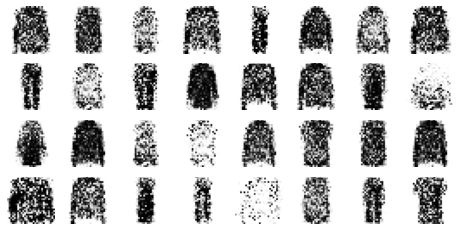

In [40]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

# Generate new images using the GAN from random noise
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)

# Show the results
plot_multiple_images(generated_images, 8)

Epoch 1/5


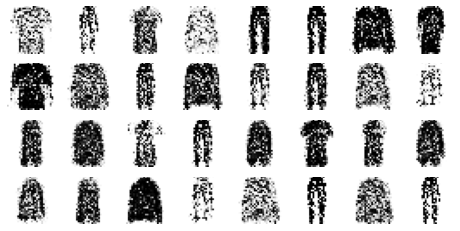

Epoch 2/5


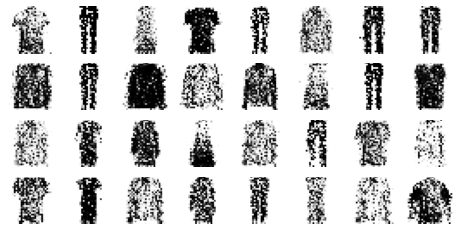

Epoch 3/5


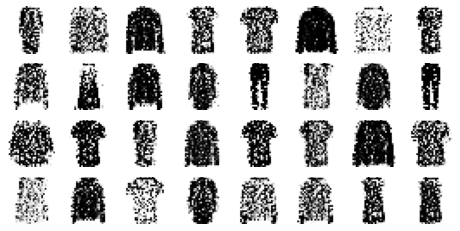

Epoch 4/5


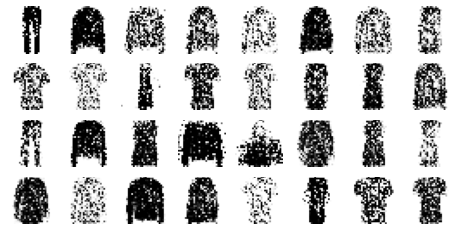

Epoch 5/5


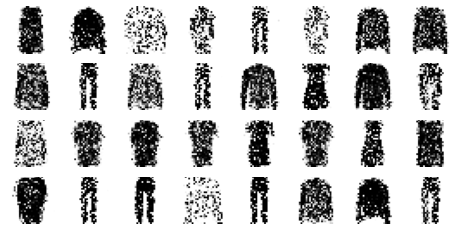

In [41]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=5)

### Deep Convolutional GAN
*Deep convolutional GANs (DCGANs)* are quite successfull in producing realistic instances (images) if one follows certain guidelines when designing the network. Following these guidelines will most likely make the training process converge:
* Replace pooling with strided convolution in the discriminator and transposed conolutions in the generator
* Use batch normalizationin both except in generator's output and discriminator's input
* Remove fully connected layers from deep models
* Use *ReLU* in the generator except for the last layer which should have *tanh*
* Use *Leaky ReLU* in the discriminator

An important technique is *progressive growing of GANs* which resembles greedy layer-wise training of stacked autoencoders. We start with small images and as the traianing continues we add more convolutional layers to both the generator and discriminator to produce larger images. See more on this in the book.

Epoch 1/10


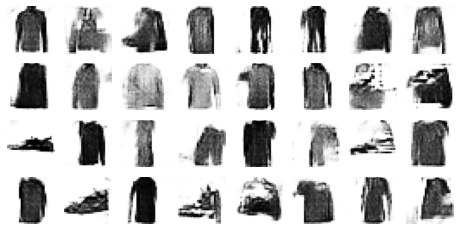

Epoch 2/10


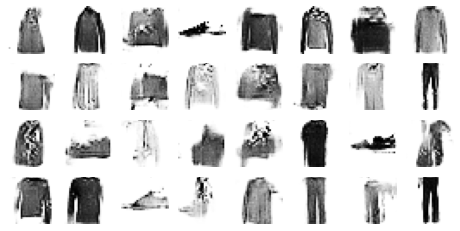

Epoch 3/10


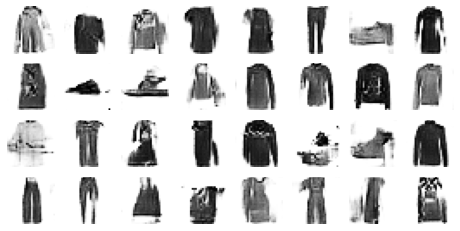

Epoch 4/10


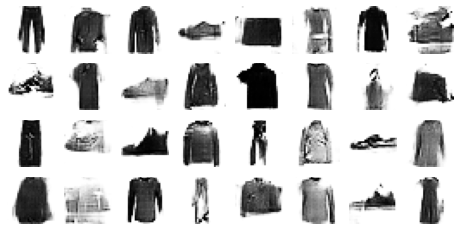

Epoch 5/10


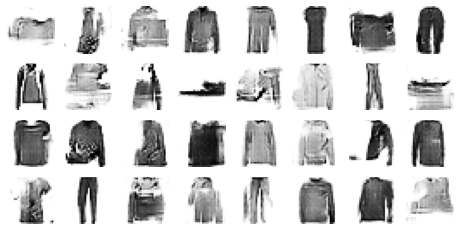

Epoch 6/10


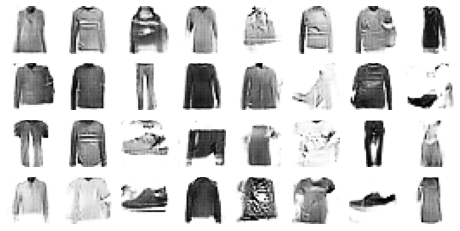

Epoch 7/10


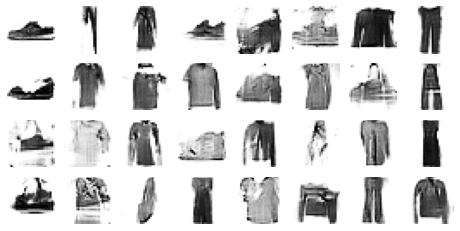

Epoch 8/10


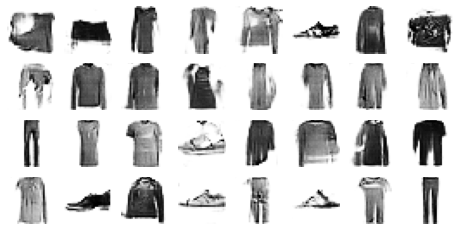

Epoch 9/10


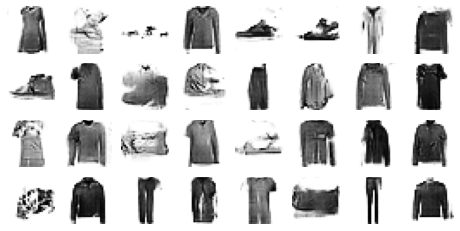

Epoch 10/10


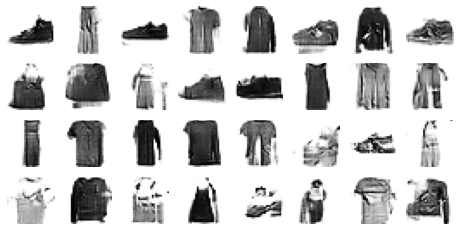

In [42]:
# Set RNG state
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

# The generator
#  - We project the 100 dimensional codings to 6272 dimensional space and reshape to 7x7x128 images
#  - Then we continously upsample the image with transposed 2D convolutions with stride 2 (7x7x128 -> 14x14x64 and so on)
#  - We use SELU instead of ReLU to make this particular model stable
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh"),
])

# The discriminator
#  - The architecture is quite similar to regular CNN for binary classification
#  - We just use leaky ReLUs and downsample the image with conv. layers with stride 2 instead of max pooling
#  - Compared to the DCGAN guidelines we replace BN with dropout to make the training stable
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid"),
])

# Compose the deep convolutional GAN
gan = keras.models.Sequential([generator, discriminator])


# Compile the discriminator and whole GAN
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Reshape and rescale the training data
#  1. We must reshape the tensor to add a channel dimension
#  2. We also have to scale the inputs to interval [-1, 1] for the tanh activation
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

# Create a TF Dataset for the training
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000).batch(batch_size, drop_remainder=True).prefetch(1)

# Run the custom training loop on our DCGAN model
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

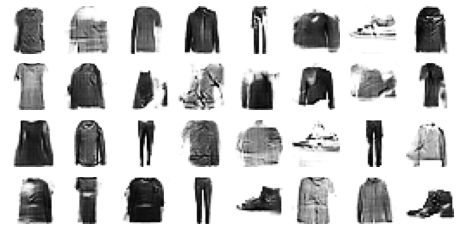

In [43]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

# Generate new images using the DCGAN from random noise
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)

# Show the results
plot_multiple_images(generated_images, 8)

### Style GANs
Another important architecture is *Style GAN* which originated from an simple problem: How do we evaluate instances (images) produced by GANs? What's been studied and applied comparing the similarity of local strucures (styles) between generated and training instances (images). Style GANs then take this idea of extracting style features and incorporate it to the architecture. The discriminator stays the same, we just extend then generator to two parts:
* **Mapping network** $f$ - maps the latent representations (codings) $\mathbf{z}$ to a vector $\mathbf{w}$ using a stack of FC layers; $\mathbf{w}$ is then passed through a set of *affine transformations* (dense layers with no activation) producing multiple style vectors each at different level
* **Synthesis network** $g$ - is responsible for generating the image. It starts with constant (after training) input is composed of a stack of conv. and upsampling layers as before with two upgrades: 1) random noise is added to both input and output of the conv. lyers and 2) each noise layer is followed by an *Adaptive Instance Normalization (AdaIN)* layer (standardizes each feature map and scales and offsets it using respective part of a style vector)

*Note: See a sketch of the architecture in the book.*

Additional important technique introduced with Style GANs is *mixing regularization* (*mixing styles*). We start with two codings $\mathbf{z}_1$ and $\mathbf{z}_2$ and produce two mappings $\mathbf{w}_1$ and $\mathbf{w}_2$ (with corresponding styles). Each time we pick a random cutoff and we use styles from $\mathbf{w}_1$ in one part of the synthesis network and $\mathbf{w}_2$ in the other. This helps breaking style correlations at adjecent levels and focuses the network on local traits.

## Exercises

### Unsupervised pretraining

In [44]:
# Set RNG state
tf.random.set_seed(42)
np.random.seed(42)

# Take small subset of the Fashion MNIST dataset
X_train_small = X_train[:500]
y_train_small = y_train[:500]

# Build a simple CNN classifier
classifier = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax"),
])
classifier.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.02), metrics=["accuracy"])

# Train and validate the model
history = classifier.fit(X_train_small, y_train_small, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
16/16 [==============================] - 2s 78ms/step - loss: 2.2651 - accuracy: 0.2093 - val_loss: 1.9777 - val_accuracy: 0.4184
Epoch 2/20
16/16 [==============================] - 1s 67ms/step - loss: 1.8718 - accuracy: 0.4904 - val_loss: 1.6259 - val_accuracy: 0.5408
Epoch 3/20
16/16 [==============================] - 1s 73ms/step - loss: 1.4719 - accuracy: 0.5774 - val_loss: 1.2588 - val_accuracy: 0.6040
Epoch 4/20
16/16 [==============================] - 1s 72ms/step - loss: 1.1272 - accuracy: 0.6733 - val_loss: 1.0043 - val_accuracy: 0.6894
Epoch 5/20
16/16 [==============================] - 1s 68ms/step - loss: 1.0436 - accuracy: 0.6335 - val_loss: 0.9228 - val_accuracy: 0.6934
Epoch 6/20
16/16 [==============================] - 1s 70ms/step - loss: 0.9582 - accuracy: 0.6486 - val_loss: 0.8603 - val_accuracy: 0.7008
Epoch 7/20
16/16 [==============================] - 1s 65ms/step - loss: 0.7986 - accuracy: 0.7431 - val_loss: 0.8095 - val_accuracy: 0.7024
Epoch 8/20
16

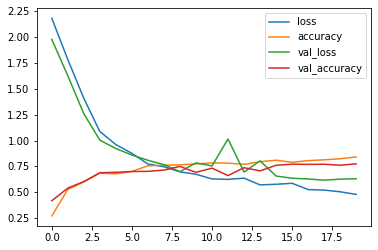

In [45]:
import pandas as pd

# Plot the learning curves
pd.DataFrame(history.history).plot()
plt.show()

In [46]:
# Reset RNG state
tf.random.set_seed(42)
np.random.seed(42)

# Clone and freeze our original conv. autoencoder (encoder part)
conv_encoder_clone = keras.models.clone_model(conv_encoder)
conv_encoder_clone.trainable = False

# Build another classifienr using the pre-trained layers from the conv. autoencoder
pretrained_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax"),
])

pretrained_clf.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(lr=0.02),
    metrics=["accuracy"],
)

# Train and validate this pre-trained model
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 1s 66ms/step - loss: 2.3378 - accuracy: 0.1521 - val_loss: 2.2306 - val_accuracy: 0.2382
Epoch 2/30
16/16 [==============================] - 1s 55ms/step - loss: 2.2126 - accuracy: 0.2548 - val_loss: 2.1302 - val_accuracy: 0.3560
Epoch 3/30
16/16 [==============================] - 1s 61ms/step - loss: 2.1059 - accuracy: 0.3816 - val_loss: 2.0362 - val_accuracy: 0.4132
Epoch 4/30
16/16 [==============================] - 1s 55ms/step - loss: 2.0001 - accuracy: 0.4831 - val_loss: 1.9561 - val_accuracy: 0.5152
Epoch 5/30
16/16 [==============================] - 1s 63ms/step - loss: 1.9365 - accuracy: 0.5318 - val_loss: 1.8746 - val_accuracy: 0.5920
Epoch 6/30
16/16 [==============================] - 1s 59ms/step - loss: 1.8599 - accuracy: 0.5879 - val_loss: 1.7987 - val_accuracy: 0.6340
Epoch 7/30
16/16 [==============================] - 1s 57ms/step - loss: 1.7754 - accuracy: 0.6632 - val_loss: 1.7221 - val_accuracy: 0.6414
Epoch 8/30
16

In [47]:
# Unfreeze the pre-trained encoder layers for final tuning
conv_encoder_clone.trainable = True

# Re-compile the model
pretrained_clf.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(lr=0.02),
    metrics=["accuracy"],
)

# Train the model for another 20 epochs
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
16/16 [==============================] - 2s 77ms/step - loss: 0.8677 - accuracy: 0.7529 - val_loss: 0.7980 - val_accuracy: 0.7214
Epoch 2/20
16/16 [==============================] - 1s 68ms/step - loss: 0.7504 - accuracy: 0.7582 - val_loss: 0.7892 - val_accuracy: 0.7208
Epoch 3/20
16/16 [==============================] - 1s 67ms/step - loss: 0.6853 - accuracy: 0.7764 - val_loss: 0.7738 - val_accuracy: 0.7088
Epoch 4/20
16/16 [==============================] - 1s 65ms/step - loss: 0.6890 - accuracy: 0.7646 - val_loss: 0.7195 - val_accuracy: 0.7304
Epoch 5/20
16/16 [==============================] - 1s 67ms/step - loss: 0.7276 - accuracy: 0.7445 - val_loss: 0.6896 - val_accuracy: 0.7430
Epoch 6/20
16/16 [==============================] - 1s 66ms/step - loss: 0.6934 - accuracy: 0.7294 - val_loss: 0.7105 - val_accuracy: 0.7298
Epoch 7/20
16/16 [==============================] - 1s 66ms/step - loss: 0.6009 - accuracy: 0.7977 - val_loss: 0.6905 - val_accuracy: 0.7348
Epoch 8/20
16

### Hashing Using a Binary Autoencoder

In [52]:
# Set RNG state
tf.random.set_seed(42)
np.random.seed(42)

hash_size = 16

# The encoder
hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(hash_size, activation="sigmoid"),
])

# The decoder
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[hash_size]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

# Compose the autoencoder model
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0), metrics=[rounded_accuracy])

# Train and validate the autoencoder using inputs as targets
history = hashing_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5250 - rounded_accuracy: 0.7116 - val_loss: 0.4856 - val_rounded_accuracy: 0.7350
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4837 - rounded_accuracy: 0.7378 - val_loss: 0.4688 - val_rounded_accuracy: 0.7676
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4367 - rounded_accuracy: 0.7912 - val_loss: 0.4235 - val_rounded_accuracy: 0.8018
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4114 - rounded_accuracy: 0.8127 - val_loss: 0.4202 - val_rounded_accuracy: 0.8053
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4036 - rounded_accuracy: 0.8181 - val_loss: 0.4119 - val_rounded_accuracy: 0.8073
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4007 - rounded_accuracy: 0.8209 - val_loss: 0.4070 - val_rounded_accuracy: 0.8126
Epoch 7/10
1719/1719 [==================

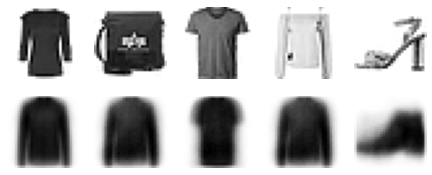

In [53]:
show_reconstructions(hashing_ae)
plt.show()

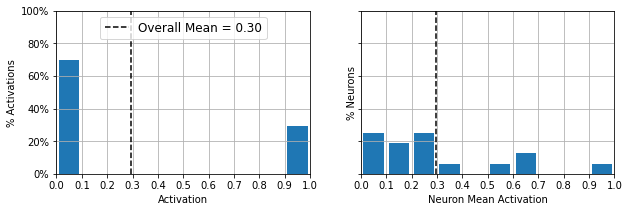

In [54]:
plot_activations_histogram(hashing_encoder)
plt.show()

In [56]:
# Compute hashes of the validation images
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(hash_size)]])
hashes = hashes.sum(axis=1)

# Show a sample of the hashes
for h in hashes[:5]:
    print(f"{h:016b}")

0101000000001001
0101000000000001
0101000100001001
0101000000000001
0001000001000100


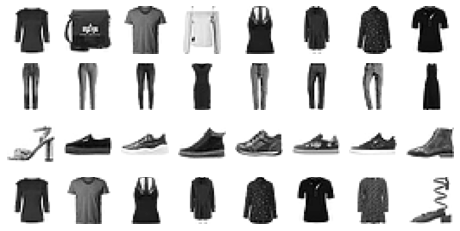

In [57]:
n_bits = 4
n_images = 8

# Plot a "Hashtable"
plt.figure(figsize=(n_images, n_bits))

for bit_index in range(n_bits):
    # Compute a mask of images in particular bucket
    in_bucket = (hashes & 2**bit_index != 0)
    
    # Plot few images from the bucket (corresponding to a hash)
    for i, image in zip(range(n_images), X_valid[in_bucket]):
        plt.subplot(n_bits, n_images, bit_index * n_images + i + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

### Pretraining a CIFAR10 classifier using denoising autoencoder

In [58]:
# Set RNG state
tf.random.set_seed(42)
np.random.seed(42)

# Load, split and scale the CIFAR10 dataset
max_val = 255
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / max_val
X_test = X_test / max_val

In [59]:
# Denoising encoder
denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

denoising_encoder.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_4 (GaussianNo (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 512)               4194816   
Total params: 4,195,712
Trainable params: 4,195,712
Non-trainable params: 0
_________________________________________________________________


In [60]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation="relu", input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
])

denoising_decoder.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 8192)              4202496   
_________________________________________________________________
reshape_15 (Reshape)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 3)         867       
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compose and train the denoising autoencoder
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(), metrics=["mse"])

history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_test, X_test))